In [1]:
# %pip install Bio

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim

import math
import numpy as np
from Bio.PDB import PDBParser



In [3]:

# -- 1) LOAD SINGLE-RESIDUE LYSINE FROM PDB --
pdb_parser = PDBParser(QUIET=True)
structure = pdb_parser.get_structure("lys", "lysine.pdb")

# Assume there's exactly one model, one chain, one residue
model = structure[0]
chain = next(model.get_chains())
res = next(chain.get_residues())

# -- 2) EXTRACT BACKBONE ATOMS & BUILD LOCAL BACKBONE FRAME --

# Grab coordinates of N, CA, and C
N_coord  = np.array(res["N"].coord)
CA_coord = np.array(res["CA"].coord)
C_coord  = np.array(res["C"].coord)

def build_backbone_frame(N, CA, C):
    """
    Build a local coordinate frame (3x3 rotation + origin) from 
    the backbone atoms N, CA, C.

    One common convention:
    - Origin = CA
    - x-axis = (CA -> C) normalized
    - y-axis = projection of (CA -> N) orthogonal to x, then normalized
    - z-axis = x cross y
    Returns:
       R (3x3 np.array) - rotation matrix
       t (3, )          - translation (the CA coordinates)
    """
    # Origin at CA
    origin = CA

    # x-axis: from CA to C (normalized)
    x = C - CA
    x /= np.linalg.norm(x)

    # provisional y-axis: from CA to N
    y = N - CA
    # remove component along x
    y -= (np.dot(y, x) * x)
    y /= np.linalg.norm(y)

    # z-axis: cross(x, y)
    z = np.cross(x, y)
    z /= np.linalg.norm(z)

    R = np.stack([x, y, z], axis=1)  # shape (3, 3)
    t = origin
    return R, t

R_frame, t_frame = build_backbone_frame(N_coord, CA_coord, C_coord)

# Convert to torch tensors
R_frame_torch = torch.tensor(R_frame, dtype=torch.float32)  # (3x3)
t_frame_torch = torch.tensor(t_frame, dtype=torch.float32)  # (3,)

# -- 3) EXTRACT CA COORDINATES (as Torch tensor) --
ca_torch = torch.tensor(CA_coord, dtype=torch.float32)

# -- 4) COMPUTE SIDECHAIN CHI ANGLES FOR LYS --
# Lys sidechain atoms: 
#    χ1: N - CA - CB - CG
#    χ2: CA - CB - CG - CD
#    χ3: CB - CG - CD - CE
#    χ4: CG - CD - CE - NZ

def dihedral_angle(a, b, c, d):
    """
    Compute dihedral angle in radians for four points 
    (each one is an np.array of shape (3,)).
    Formula based on cross/cross method.
    """
    b1 = b - a
    b2 = c - b
    b3 = d - c
    
    # normal to plane 1
    n1 = np.cross(b1, b2)
    # normal to plane 2
    n2 = np.cross(b2, b3)
    
    # normalize
    n1 /= np.linalg.norm(n1)
    n2 /= np.linalg.norm(n2)
    
    # direction of b2 for sign of angle
    m1 = np.cross(n1, b2 / np.linalg.norm(b2))
    x = np.dot(n1, n2)
    y = np.dot(m1, n2)
    angle = -math.atan2(y, x)  # negative to match common convention
    return angle

atom_names = ["N","CA","CB","CG","CD","CE","NZ"]
coords = {an: np.array(res[an].coord) for an in atom_names}

chi1 = dihedral_angle(coords["N"],  coords["CA"], coords["CB"], coords["CG"])
chi2 = dihedral_angle(coords["CA"], coords["CB"], coords["CG"], coords["CD"])
chi3 = dihedral_angle(coords["CB"], coords["CG"], coords["CD"], coords["CE"])
chi4 = dihedral_angle(coords["CG"], coords["CD"], coords["CE"], coords["NZ"])

# Store sidechain chi angles in a torch tensor (radians)
chi_torch = torch.tensor([chi1, chi2, chi3, chi4], dtype=torch.float32)

# -- 5) Print or use the results --
print("Backbone rotation (R_frame_torch):\n", R_frame_torch)
print("Backbone origin (t_frame_torch):\n", t_frame_torch)
print("C-alpha coordinate:", ca_torch)
print("Chi angles (radians):", chi_torch)


Backbone rotation (R_frame_torch):
 tensor([[-0.8000,  0.6000,  0.0000],
        [ 0.6000,  0.8000,  0.0000],
        [ 0.0000,  0.0000, -1.0000]])
Backbone origin (t_frame_torch):
 tensor([0.0000, 1.2000, 0.0000])
C-alpha coordinate: tensor([0.0000, 1.2000, 0.0000])
Chi angles (radians): tensor([-0.6559, -1.7392, -3.1416, -3.1416])


In [4]:
import math
import torch

# Suppose these are your typical Lys bond lengths and angles in ANGSTROMS / DEGREES.
# (Actual values can be refined from a force field or PDB monomer library.)
BOND_LENGTHS = {
    ('N', 'CA'): 1.500,
    ('CA', 'C'): 1.500,
    ('C', 'O'): 1.077,
    ('CA', 'CB'): 1.628,
    ('CB', 'CG'): 1.578,
    ('CG', 'CD'): 1.612,
    ('CD', 'CE'): 1.578,
    ('CE', 'NZ'): 1.612,

}
BOND_ANGLES = {
    # e.g. angle at CA in N-CA-CB; but for sidechain we can approximate these as ~109-113 deg
    ('N', 'CA', 'C'): 106.260,
    ('CA', 'C', 'O'): 121.329,
    ('N', 'CA', 'CB'): 116.250,
    ('CA', 'CB', 'CG'): 123.025,
    ('CB', 'CG', 'CD'): 108.326,
    ('CG', 'CD', 'CE'): 108.326,
    ('CD', 'CE', 'NZ'): 108.326,
}

def place_atom_ic(refA, refB, refC, bond_length, bond_angle_deg, dihedral_deg):
    """
    Place a new atom X given references A,B,C in 3D:
      - We want the new atom X such that:
          BX = bond_length
          angle( A-B-X ) = bond_angle_deg
          dihedral( A-B-C-X ) = dihedral_deg
    Returns the 3D coordinate (torch tensor of shape (3,)) for the newly placed atom X.

    The typical formula uses vector math:
      1) Put B at origin (temporary),
      2) Place C in xz-plane,
      3) Rotate around the x-axis to get angle,
      4) Rotate around the z-axis to get dihedral,
      5) Then translate back.

    This is a standard "internal-coordinates to cartesian" routine.
    """
    # 1) Define the three references in local float form
    A = refA.float()
    B = refB.float()
    C = refC.float()

    # 2) Make vectors AB, CB
    AB = A - B

    CB = C - B

    # 3) Construct local axes
    #    The "bond" axis is B->C in xz-plane,
    #    then B->A sets the orientation of x-axis or y-axis, etc.

    # e1 = unit(CB)
    e1 = CB / (CB.norm() + 1e-8)

    # v = AB - (AB·e1)*e1
    # This is part of the plane that defines "angle"
    v = AB - torch.dot(AB, e1) * e1
    vnorm = v.norm() + 1e-8
    e2 = v / vnorm  # normalized in-plane axis

    # e3 = e1 x e2
    e3 = torch.cross(e1, e2)

    # Now (e1, e2, e3) form an orthonormal basis.
    # e1 = "plane" direction from B to C
    # e2 = "in-plane" direction from B to A
    # e3 = perpendicular to that plane

    # 4) We apply bond length, bond angle, dihedral to find the new point X in that local frame
    bond_angle_rad = bond_angle_deg * math.pi / 180.0
    dihedral_rad   = dihedral_deg * math.pi / 180.0

    # In standard formula: 
    #   X_in_local = [ 
    #     + bond_length*cos(bond_angle), 
    #     + bond_length*sin(bond_angle)*cos(dihedral),
    #     - bond_length*sin(bond_angle)*sin(dihedral)
    #   ]
    # Then we map that back to global using (e1,e2,e3) plus B.
    #
    # Note that the signs on the sin() terms can vary depending on the chosen convention.
    # The snippet below is one common version:

    l = bond_length
    alpha = bond_angle_rad
    theta = dihedral_rad

    # Coordinates of X in the (e1,e2,e3) local basis:
    x_local = torch.zeros(3, dtype=torch.float32)
    x_local[0] = l * math.cos(alpha)
    x_local[1] = l * math.sin(alpha) * math.cos(theta)
    x_local[2] = l * math.sin(alpha) * math.sin(theta)

    # Convert local to global
    X = B + x_local[0] * e1 + x_local[1] * e2 + x_local[2] * e3
    return X

def build_lysine_coords_from_tensors(
    R_frame_torch : torch.Tensor,   # (3,3) rotation 
    t_frame_torch : torch.Tensor,   # (3,)   translation
    chi_torch     : torch.Tensor,   # (4,)   chi angles in RADIANS
    
):
    """
    Build Lysine sidechain coords from scratch using internal coords and the four chi angles.
    We assume backbone_local is a dict containing local-frame coords for N, CA, C, O.
        e.g. backbone_local["N"] = torch.tensor([xN, yN, zN])
             backbone_local["CA"]= torch.tensor([0.0, 0.0, 0.0]) # maybe
             ...
    Steps:
      1) Place CB from (N, CA, C) with a default 'dihedral' that sets initial sidechain orientation. 
         (Often you can set it to 180 or something standard.)
      2) Then place CG with bond_length=1.52, bond_angle=109.5, dihedral = chi1.
      3) Then place CD with dihedral = chi2, ...
      4) Then place CE with dihedral = chi3
      5) Then place NZ with dihedral = chi4
    6) Transform all local coords to global by coords_local @ R^T + t.
    """

    # Using approximate positions in an 'ideal' extended conformation:
    # CA at origin:
    CA_local = torch.tensor([0 ,0,  0], dtype=torch.float32)
    
    # Place N so that N-CA = 1.458 Å along +y:
    N_local = torch.tensor([-4.2000e-01,  1.4400e+00,  0.0000e+00], dtype=torch.float32)
    
    # Place C so that CA-C = 1.525 Å along +x:
   
    C_local = torch.tensor([1.5000e+00,  7.6294e-08,  0.0000e+00], dtype=torch.float32)


    O_local = torch.tensor( [ 2.0600e+00, -9.2000e-01,  0.0000e+00], dtype=torch.float32)

    
   
    backbone_local_ideal = {
        "N"  : N_local,
        "CA" : CA_local,
        "C"  : C_local,
        "O"  : O_local,
    }

    # Convert chi angles from radians to degrees, if needed:
    chi_deg = chi_torch * 180.0 / math.pi  # shape (4,)

    # We'll accumulate local coords of sidechain in a dict as well
    sc = {}  # sidechain coords in local frame

    # --- 1) Place CB ---
    # Typically, the reference is (N,CA,C) for building CB.
    # We'll pick a "dummy" dihedral for placing CB (some standard guess).
    sc["CB"] =  torch.tensor( [ 0.0000e+00,  0.0000e+00, -1.1000e+00], dtype=torch.float32)
    # --- 2) Place CG ---
    # For CG, references are typically (N, CA, CB) to define chi1 about CA-CB.
    # The dihedral is the user-provided chi1 (in degrees).
    sc["CG"] = place_atom_ic(
        backbone_local_ideal["N"],       # A
        backbone_local_ideal["CA"],      # B
        sc["CB"],                  # C
        bond_length = BOND_LENGTHS[("CB","CG")],
        bond_angle_deg = BOND_ANGLES[("CA","CB","CG")],
        dihedral_deg = chi_deg[0].item(),  # chi1
    )

    # --- 3) Place CD ---
    # For CD, references are (CA, CB, CG) to define chi2 about CB-CG.
    sc["CD"] = place_atom_ic(
        backbone_local_ideal["CA"],   # A
        sc["CB"],               # B
        sc["CG"],               # C
        bond_length = BOND_LENGTHS[("CG","CD")],
        bond_angle_deg = BOND_ANGLES[("CB","CG","CD")],
        dihedral_deg = chi_deg[1].item(),  # chi2
    )

    # --- 4) Place CE ---
    # references (CB, CG, CD) => chi3 about CG-CD
    sc["CE"] = place_atom_ic(
        sc["CB"],     # A
        sc["CG"],     # B
        sc["CD"],     # C
        bond_length = BOND_LENGTHS[("CD","CE")],
        bond_angle_deg = BOND_ANGLES[("CG","CD","CE")],
        dihedral_deg = chi_deg[2].item(),  # chi3
    )

    # --- 5) Place NZ ---
    # references (CG, CD, CE) => chi4 about CD-CE
    sc["NZ"] = place_atom_ic(
        sc["CG"],     # A
        sc["CD"],     # B
        sc["CE"],     # C
        bond_length = BOND_LENGTHS[("CE","NZ")],
        bond_angle_deg = BOND_ANGLES[("CD","CE","NZ")],
        dihedral_deg = chi_deg[3].item(),  # chi4
    )

    # --- Gather final local coords ---
    coords_local = []
    atom_order   = ["N","CA","C","O","CB","CG","CD","CE","NZ"]
    print(backbone_local_ideal)
    # We assume backbone_local includes N, CA, C, O in the same coordinate system:
    coords_local.append(backbone_local_ideal["N"])
    coords_local.append(backbone_local_ideal["CA"])
    coords_local.append(backbone_local_ideal["C"])
    coords_local.append(backbone_local_ideal["O"])
    coords_local.append(sc["CB"])
    coords_local.append(sc["CG"])
    coords_local.append(sc["CD"])
    coords_local.append(sc["CE"])
    coords_local.append(sc["NZ"])
    # print(coords_local)
    coords_local = torch.stack(coords_local, dim=0)  # (9, 3)

    # --- 6) Transform local -> global: X_global = X_local @ R^T + t
    R = R_frame_torch  # (3,3)
    t = t_frame_torch  # (3,)
    print(coords_local @ R)
    coords_global = coords_local @ R + t

    return coords_global  # shape (9,3)


In [5]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def visualize_molecule(atom_positions_torch, atom_names, bond_pairs, figsize=(6,6)):
    """
    Simple 3D scatter + lines (bonds) visualization using matplotlib.
      - atom_positions_torch: (N, 3) tensor
      - atom_names:           list of length N (atom_order)
      - bond_pairs:           list of (atom_name1, atom_name2)
    """
    coords_np = atom_positions_torch.detach().cpu().numpy()
    xs = coords_np[:, 0]
    ys = coords_np[:, 1]
    zs = coords_np[:, 2]
    
    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(111, projection='3d')
    
    # Scatter plot
    ax.scatter(xs, ys, zs, c="red", s=50)
    
    # Label each atom
    for i, atom_name in enumerate(atom_names):
        ax.text(xs[i], ys[i], zs[i], atom_name, size=9, zorder=10)
    
    # Connect bonds
    name_to_idx = {name: i for i, name in enumerate(atom_names)}
    for (a1, a2) in bond_pairs:
        if a1 in name_to_idx and a2 in name_to_idx:
            i1, i2 = name_to_idx[a1], name_to_idx[a2]
            ax.plot([xs[i1], xs[i2]],
                    [ys[i1], ys[i2]],
                    [zs[i1], zs[i2]],
                    color='black', linewidth=2)
    
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_zlabel("Z")
    ax.set_title("Lysine Visualization")
    plt.show()


In [6]:
bond_pairs = [
    ("N", "CA"), ("CA", "C"), ("C", "O"), 
    ("CA", "CB"), ("CB", "CG"), ("CG", "CD"), 
    ("CD", "CE"), ("CE", "NZ")
]


{'N': tensor([-0.4200,  1.4400,  0.0000]), 'CA': tensor([0., 0., 0.]), 'C': tensor([1.5000e+00, 7.6294e-08, 0.0000e+00]), 'O': tensor([ 2.0600, -0.9200,  0.0000])}
tensor([[ 1.2000,  0.9000,  0.0000],
        [ 0.0000,  0.0000,  0.0000],
        [-1.2000,  0.9000,  0.0000],
        [-2.2000,  0.5000,  0.0000],
        [ 0.0000,  0.0000,  1.1000],
        [ 1.3229, -0.0164, -0.8600],
        [-0.0896, -1.5076,  1.6636],
        [ 2.1000, -1.0993, -1.7047],
        [-0.0781, -3.0620,  2.0903]])


/tmp/ipykernel_1408673/3953091997.py:70: UserWarning: Using torch.cross without specifying the dim arg is deprecated.
Please either pass the dim explicitly or simply use torch.linalg.cross.
The default value of dim will change to agree with that of linalg.cross in a future release. (Triggered internally at /opt/conda/conda-bld/pytorch_1720538456841/work/aten/src/ATen/native/Cross.cpp:62.)
  e3 = torch.cross(e1, e2)


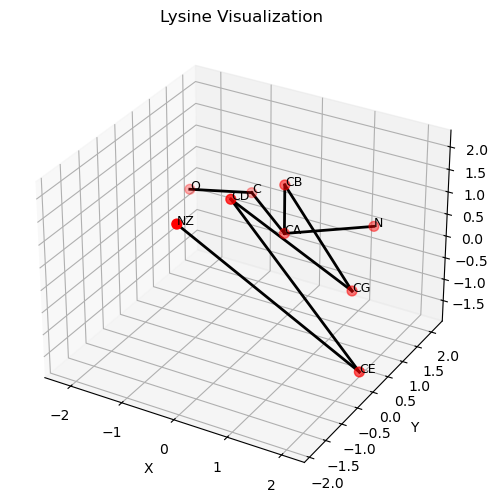

In [7]:


# Build the final coords with the chosen chi angles:
lys_final_coords = build_lysine_coords_from_tensors(
    R_frame_torch,
    t_frame_torch,
    chi_torch
    
)

# Now visualize
atom_order = ["N","CA","C","O","CB","CG","CD","CE","NZ"]
visualize_molecule(lys_final_coords, atom_order, bond_pairs)


In [8]:
chi_torch

tensor([-0.6559, -1.7392, -3.1416, -3.1416])

In [9]:
t_frame_torch

tensor([0.0000, 1.2000, 0.0000])

In [10]:
import torch
import math

# Atom coordinates from the PDB
atoms = {
    "N": torch.tensor([1.200, 2.100, 0.000], dtype=torch.float32),
    "CA": torch.tensor([0.000, 1.200, 0.000], dtype=torch.float32),
    "C": torch.tensor([-1.200, 2.100, 0.000], dtype=torch.float32),
    "O": torch.tensor([-2.200, 1.700, 0.000], dtype=torch.float32),
    "CB": torch.tensor([0.000, 0.000, 1.100], dtype=torch.float32),
    "CG": torch.tensor([1.300, -0.800, 1.500], dtype=torch.float32),
    "CD": torch.tensor([1.300, -2.200, 0.700], dtype=torch.float32),
    "CE": torch.tensor([2.600, -3.000, 1.100], dtype=torch.float32),
    "NZ": torch.tensor([2.600, -4.400, 0.300], dtype=torch.float32),
}

# Helper function to calculate distance between two points
def calc_distance(atom1, atom2):
    return torch.norm(atom1 - atom2).item()

# Helper function to calculate angle between three points
def calc_angle(atom1, atom2, atom3):
    vec1 = atom1 - atom2
    vec2 = atom3 - atom2
    cos_angle = torch.dot(vec1, vec2) / (torch.norm(vec1) * torch.norm(vec2))
    angle = torch.acos(cos_angle).item() * 180.0 / math.pi  # Convert to degrees
    return angle

# Bond lengths
bond_lengths = {
    ("N", "CA"): calc_distance(atoms["N"], atoms["CA"]),
    ("CA", "C"): calc_distance(atoms["CA"], atoms["C"]),
    ("C", "O"): calc_distance(atoms["C"], atoms["O"]),
    ("CA", "CB"): calc_distance(atoms["CA"], atoms["CB"]),
    ("CB", "CG"): calc_distance(atoms["CB"], atoms["CG"]),
    ("CG", "CD"): calc_distance(atoms["CG"], atoms["CD"]),
    ("CD", "CE"): calc_distance(atoms["CD"], atoms["CE"]),
    ("CE", "NZ"): calc_distance(atoms["CE"], atoms["NZ"]),
}

# Bond angles
bond_angles = {
    ("N", "CA", "C"): calc_angle(atoms["N"], atoms["CA"], atoms["C"]),
    ("CA", "C", "O"): calc_angle(atoms["CA"], atoms["C"], atoms["O"]),
    ("N", "CA", "CB"): calc_angle(atoms["N"], atoms["CA"], atoms["CB"]),
    ("CA", "CB", "CG"): calc_angle(atoms["CA"], atoms["CB"], atoms["CG"]),
    ("CB", "CG", "CD"): calc_angle(atoms["CB"], atoms["CG"], atoms["CD"]),
    ("CG", "CD", "CE"): calc_angle(atoms["CG"], atoms["CD"], atoms["CE"]),
    ("CD", "CE", "NZ"): calc_angle(atoms["CD"], atoms["CE"], atoms["NZ"]),
}

# Output results
print("Bond Lengths (Å):")
for bond, length in bond_lengths.items():
    print(f"{bond}: {length:.3f}")

print("\nBond Angles (°):")
for angle, value in bond_angles.items():
    print(f"{angle}: {value:.3f}")


Bond Lengths (Å):
('N', 'CA'): 1.500
('CA', 'C'): 1.500
('C', 'O'): 1.077
('CA', 'CB'): 1.628
('CB', 'CG'): 1.578
('CG', 'CD'): 1.612
('CD', 'CE'): 1.578
('CE', 'NZ'): 1.612

Bond Angles (°):
('N', 'CA', 'C'): 106.260
('CA', 'C', 'O'): 121.329
('N', 'CA', 'CB'): 116.250
('CA', 'CB', 'CG'): 123.025
('CB', 'CG', 'CD'): 108.326
('CG', 'CD', 'CE'): 108.326
('CD', 'CE', 'NZ'): 108.326


In [11]:
CA_local = torch.tensor([0.0000, 0.0000, 0.0000], dtype=torch.float32)

# Place N so that N-CA = 1.458 Å along +y:
N_local = torch.tensor([1.2, 0.9, 0.0000], dtype=torch.float32)

# Place C so that CA-C = 1.525 Å along +x:

C_local = torch.tensor([-1.2, 0.9, 0.0000], dtype=torch.float32)


O_local = torch.tensor([-2.2, 0.5, 0.0000], dtype=torch.float32)

CB_local = torch.tensor([ 0.000,   0.000,   1.100 ], dtype=torch.float32)

backbone_local_ideal = {
"N"  : N_local,
"CA" : CA_local,
"C"  : C_local,
"O"  : O_local,

}

coords_global = []
coords_global.append(backbone_local_ideal["N"])
coords_global.append(backbone_local_ideal["CA"])
coords_global.append(backbone_local_ideal["C"])
coords_global.append(backbone_local_ideal["O"])
coords_global.append(CB_local)
coords_global =torch.stack(coords_global, dim=0)
coords_global @R_frame_torch.T




tensor([[-4.2000e-01,  1.4400e+00,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00],
        [ 1.5000e+00,  5.9605e-08,  0.0000e+00],
        [ 2.0600e+00, -9.2000e-01,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00, -1.1000e+00]])

In [26]:
import numpy as np
import math

# original coords
N_real  = coords["N"]   # shape (3,)
CA_real = coords["CA"]
C_real  = np.array([ 0, 0,  0])
CB_real = coords["CB"]

# measure real dihedral
cb_dihedral = dihedral_angle(N_real, CA_real, C_real, CB_real)
cb_dihedral_deg = cb_dihedral * 180.0 / math.pi

# measure real bond length CA–CB
ca_cb_bond_length = np.linalg.norm(CB_real - CA_real)

# measure real angle (N, CA, CB)
vec_CA_N  = N_real  - CA_real
vec_CA_CB = CB_real - CA_real
dotval    = np.dot(vec_CA_N, vec_CA_CB)
angle_CA  = math.degrees(
    math.acos( dotval / (np.linalg.norm(vec_CA_N)*np.linalg.norm(vec_CA_CB)) )
)

print("Dihedral (N,CA,C,CB) in deg   =", cb_dihedral_deg)
print("Bond length CA–CB in Å        =", ca_cb_bond_length)
print("Angle (N,CA,CB) in deg        =", angle_CA)

# Now replicate in local coords:
# Suppose we have "N_local, CA_local, C_local" that match the real lengths/angles:
test = place_atom_ic(
    N_local,
    CA_local,
    C_local,
    bond_length    = ca_cb_bond_length,  # from real
    bond_angle_deg = angle_CA,
    dihedral_deg   = cb_dihedral_deg     # from real
)

# Then transform local->global if needed, or just compare directly
print("CB_local placed   =", test)
CB_global = test @ R_frame.transpose(0,1) + t_frame
print("CB_global placed  =", CB_global)
print("CB_real original  =", CB_real)



Dihedral (N,CA,C,CB) in deg   = 1.5707963267948966
Bond length CA–CB in Å        = 1.6278821
Angle (N,CA,CB) in deg        = 116.25024221255946
CB_local placed   = tensor([ 1.4517,  0.7356, -0.0400])
CB_global placed  = tensor([-0.7200,  2.6595,  0.0400])
CB_real original  = [0.  0.  1.1]


In [14]:
coords


{'N': array([1.2, 2.1, 0. ], dtype=float32),
 'CA': array([0. , 1.2, 0. ], dtype=float32),
 'CB': array([0. , 0. , 1.1], dtype=float32),
 'CG': array([ 1.3, -0.8,  1.5], dtype=float32),
 'CD': array([ 1.3, -2.2,  0.7], dtype=float32),
 'CE': array([ 2.6, -3. ,  1.1], dtype=float32),
 'NZ': array([ 2.6, -4.4,  0.3], dtype=float32)}